# I. Import libraries and dataset 

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
import ta
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [2]:
PNJ = pd.read_csv('../Datasets/PNJ.csv')

# II. EDA 

## 1. Statistic

In [3]:
PNJ

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0
...,...,...,...,...,...,...,...,...
125304,PNJ,12/22/2020 14:22,78.20,78.20,78.20,78.20,5000,0
125305,PNJ,12/22/2020 14:23,78.20,78.20,78.20,78.20,1700,0
125306,PNJ,12/22/2020 14:24,78.20,78.20,78.20,78.20,870,0
125307,PNJ,12/22/2020 14:25,78.10,78.10,78.10,78.10,13000,0


In [4]:
PNJ.describe()

,Open,High,Low,Close,Volume,Open Interest
count,125309.000000,125309.000000,125309.000000,125309.000000,125309.000000,125309.0
mean,72.182052,72.372590,72.042287,72.179371,3031.830451,0.0
std,9.900263,9.995786,9.830847,9.899401,7248.952968,0.0
min,44.430000,44.530000,44.040000,44.140000,1.000000,0.0
25%,64.600000,64.700000,64.570000,64.600000,220.000000,0.0
50%,72.800000,73.010000,72.640000,72.830000,1000.000000,0.0
75%,80.160000,80.350000,80.060000,80.160000,3130.000000,0.0
max,100.160000,100.160000,100.160000,100.160000,580730.000000,0.0


- Dataset PNJ gồm có 97406 samples, là các dữ liệu về giá OHLC, volumne, open interest của mã cổ phiếu PNJ, được ghi nhận từ ngày 25/12/2018 đến 22/12/2020.
- Các giá trị đều nằm trong khoảng hợp lệ (không có giá trị nào âm).

In [5]:
PNJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125309 entries, 0 to 125308
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         125309 non-null  object 
 1   Date/Time      125309 non-null  object 
 2   Open           125309 non-null  float64
 3   High           125309 non-null  float64
 4   Low            125309 non-null  float64
 5   Close          125309 non-null  float64
 6   Volume         125309 non-null  int64  
 7   Open Interest  125309 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 7.6+ MB


In [ ]:
PNJ.duplicated().sum()

0

- Dataset khá clean khi không có missing và duplicated value.
- Tuy nhiên các mốc thời gian ghi nhận trong dataset lại rời rạc và chỉ ghi nhận một vài thời điểm trong ngày.

## 2. Close price visualization

- Dataset sẽ được gộp lại, thành ghi nhận theo ngày.

In [7]:
from preprocessing import aggregate_intraday_to_daily

In [8]:
PNJ = aggregate_intraday_to_daily(PNJ)

In [9]:
PNJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    709 non-null    object 
 1   Open    709 non-null    float64
 2   High    709 non-null    float64
 3   Low     709 non-null    float64
 4   Close   709 non-null    float64
 5   Volume  709 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 33.4+ KB


- Sau khi gộp lại theo ngày, số samples giảm xuống còn lại 499 samples.

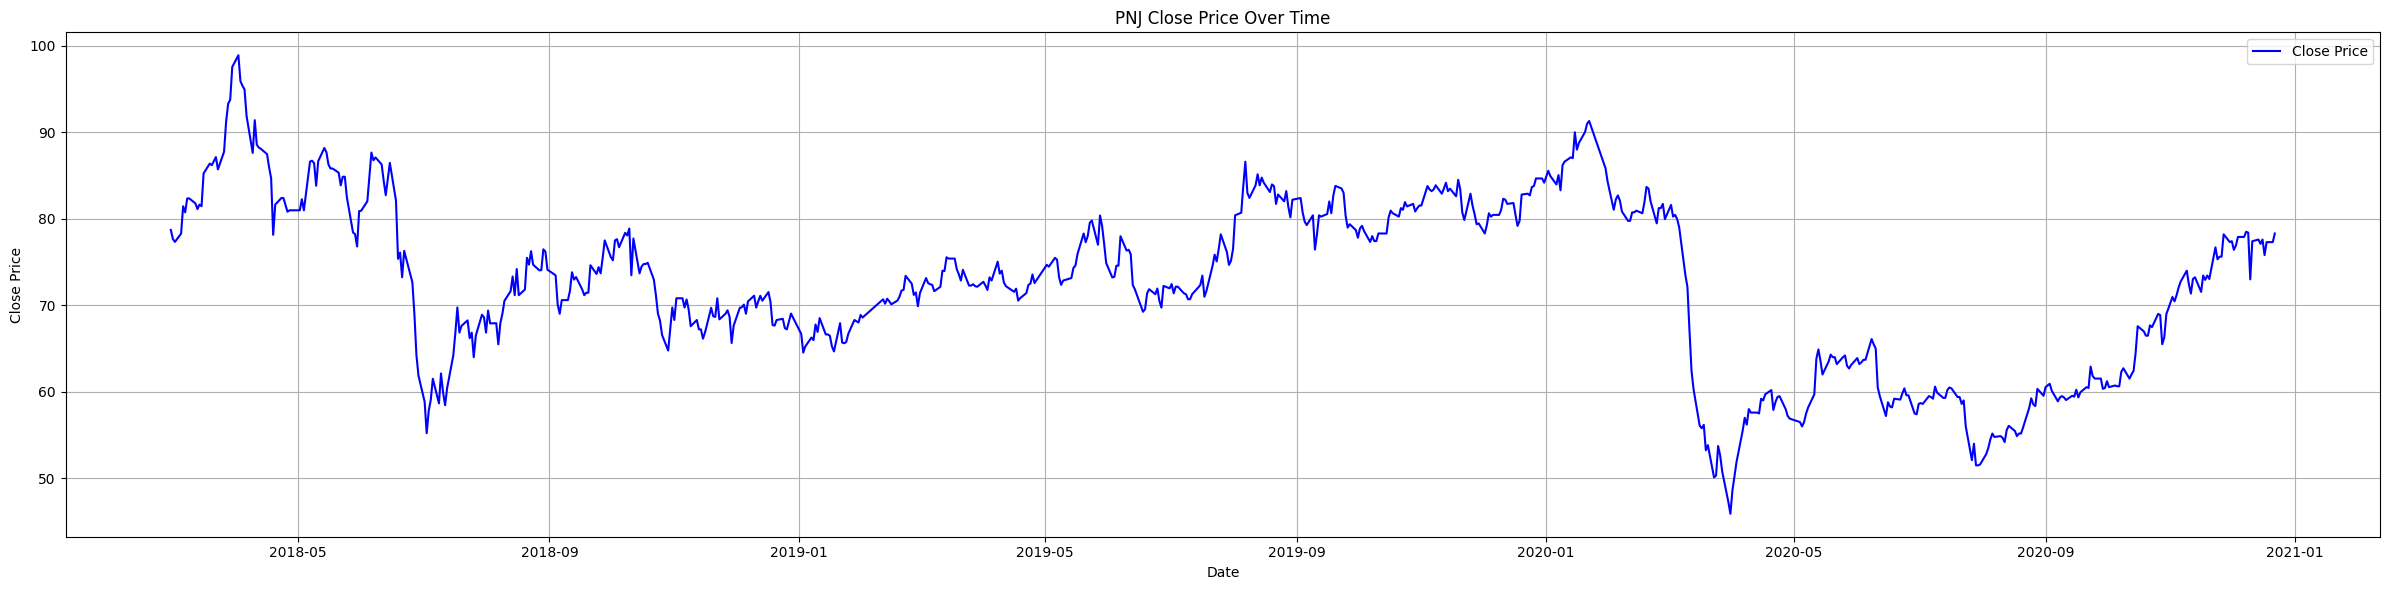

In [10]:
plt.figure(figsize=(24, 6))
plt.plot(PNJ['Date'], PNJ['Close'], label='Close Price', color='blue')
plt.title('PNJ Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Giá cổ phiếu PNJ nhìn chung có xu hướng tăng từ hơn 30.000/cổ phiếu đến gần 60.000/cổ phiếu.
- Giai đoạn đầu năm 2020 có sự biến động mạnh, giá giảm từ 48.000/cổ phiếu xuống còn 35.000/cổ phiếu. Điều này có thể do tác động của đại dịch COVID-19.

## 3. Volume over time

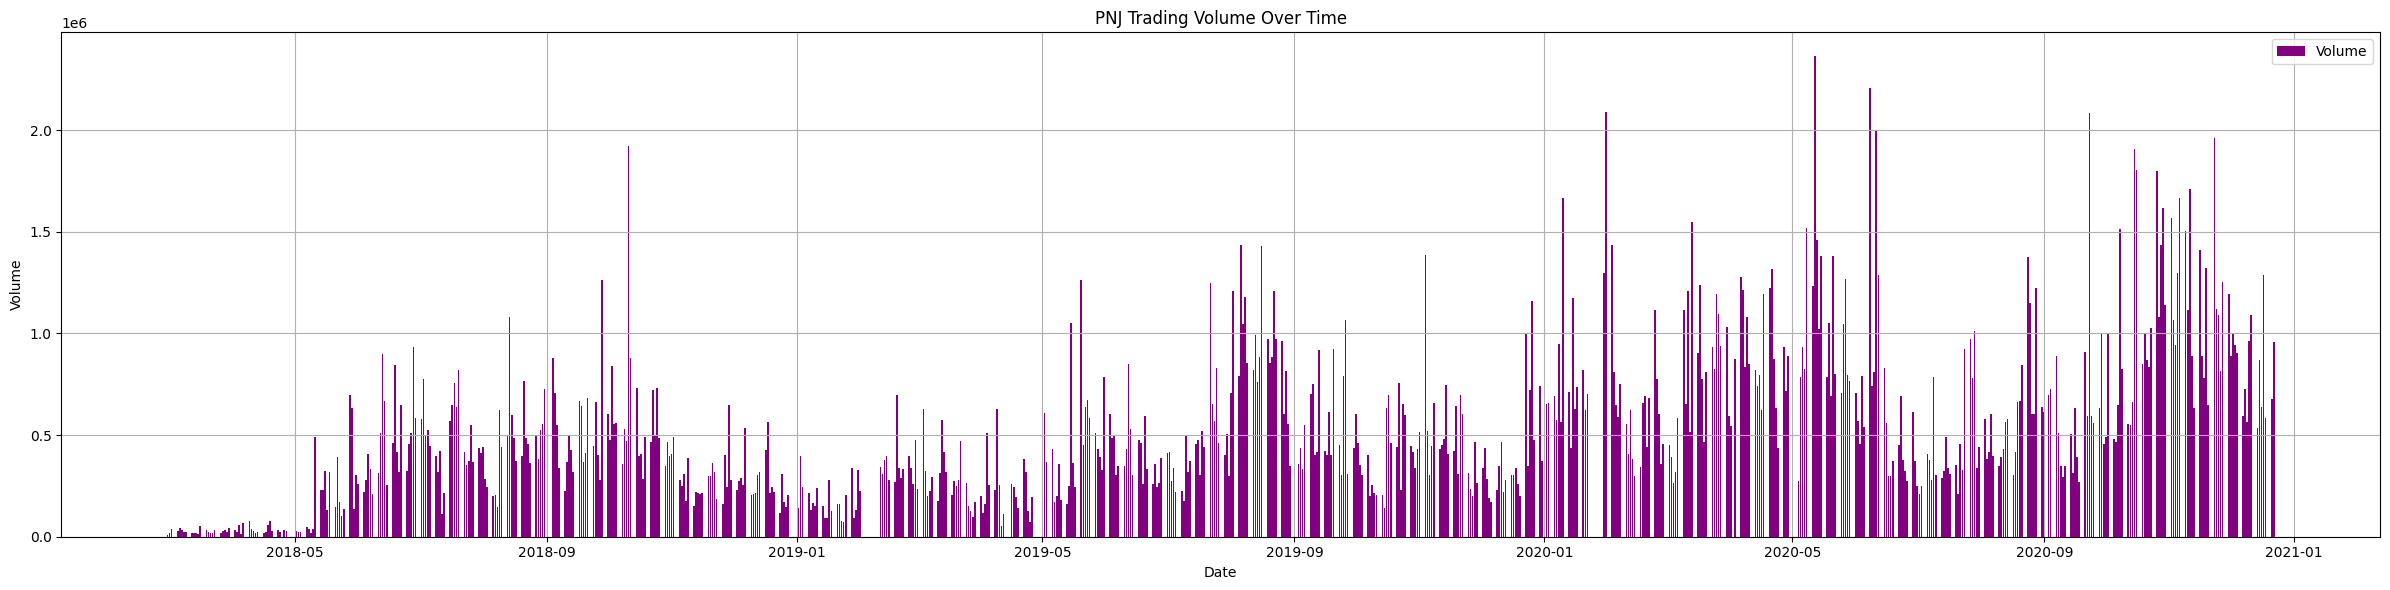

In [11]:
plt.figure(figsize=(24, 6))
plt.bar(PNJ['Date'], PNJ['Volume'], color='purple', label='Volume')
plt.title('PNJ Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Volume có sự biến động mạnh và chênh lệch lớn giữa các ngày, do việc gộp dữ liệu ở trên.

## 4. Rate of return

In [12]:
from preprocessing import return_volatility_target

In [13]:
PNJ = return_volatility_target(PNJ)

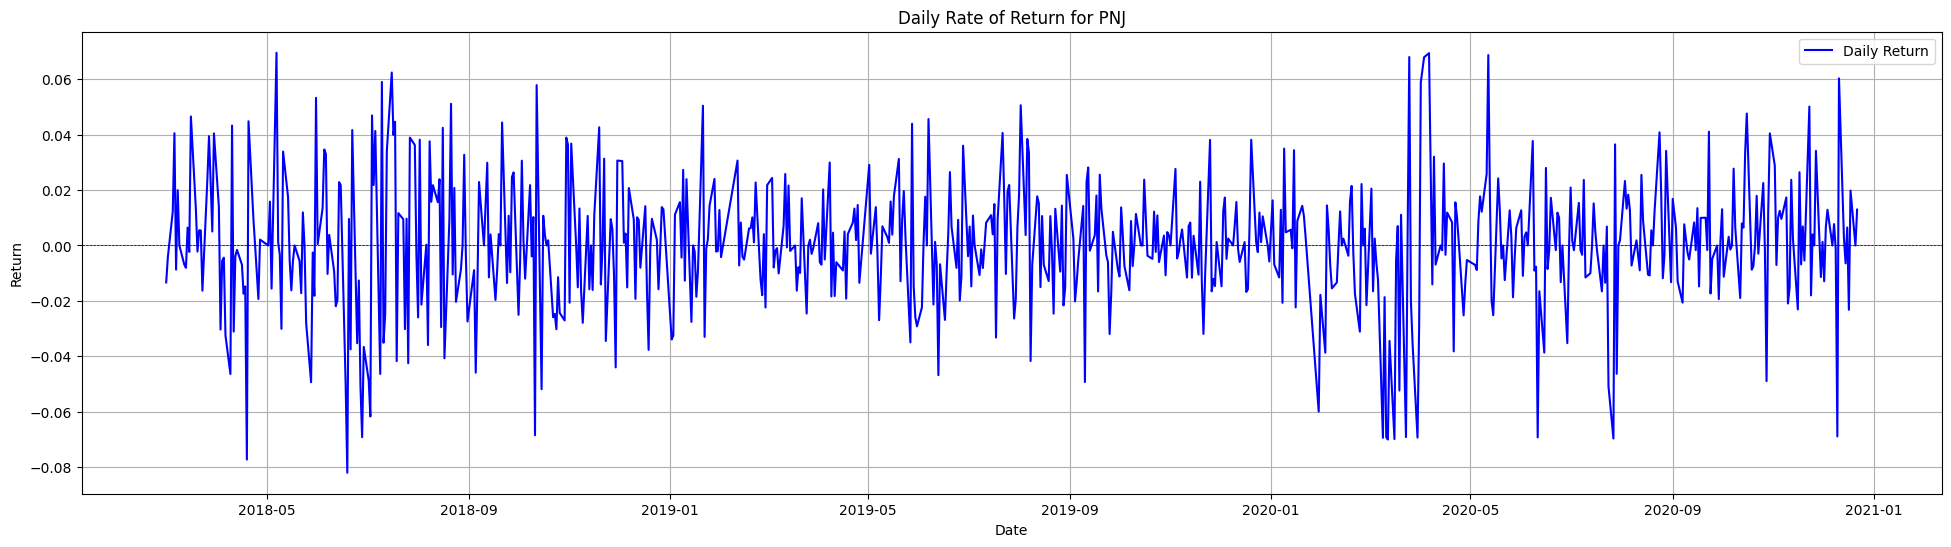

In [14]:
plt.figure(figsize=(24, 6))
plt.plot(PNJ['Date'], PNJ['Return'], label='Daily Return', color='blue')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title('Daily Rate of Return for PNJ')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

- Biên độ dao động lớn, đặc biệt vào khoảng đầu năm 2020 (khả năng do ảnh hưởng COVID-19).
- Đường lợi suất dao động quanh mức 0, không có xu hướng rõ ràng tăng hay giảm dài hạn.
- Có nhiều ngày biến động mạnh (cả tăng và giảm), cho thấy cổ phiếu có mức độ rủi ro ngắn hạn khá cao.

## 5. Volatility 

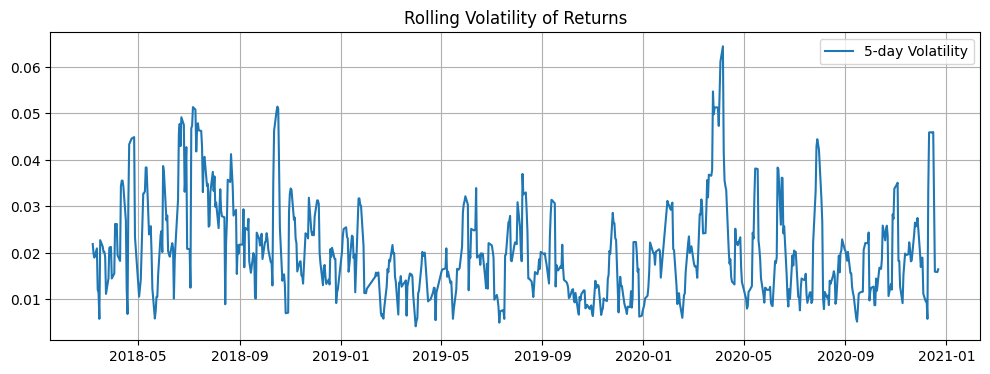

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(PNJ['Date'], PNJ['volatility_5'], label='5-day Volatility')
plt.title('Rolling Volatility of Returns')
plt.grid(True)
plt.legend()
plt.show()

- Biến động có xu hướng dao động mạnh theo chu kỳ, với nhiều đợt tăng đột biến.
- Đỉnh biến động lớn nhất xuất hiện vào khoảng tháng 3–4 năm 2020, trùng với giai đoạn khủng hoảng do COVID-19.
- Ngoài ra, các giai đoạn đầu 2018 và giữa 2019 cũng ghi nhận mức biến động khá cao. Trong các giai đoạn còn lại, độ biến động duy trì ở mức tương đối thấp.

# III. Preprocessing data 

## 1. Removing Outliers 

In [16]:
from preprocessing import remove_outliers_and_plot

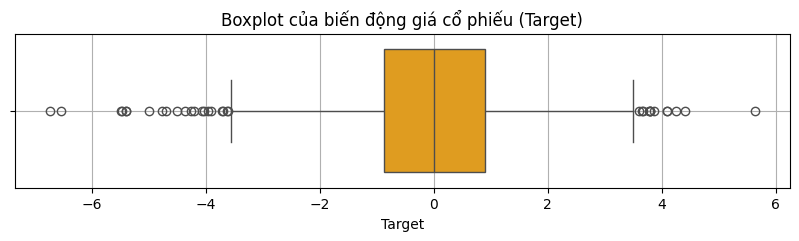

Số dòng còn lại sau khi loại outliers: 674


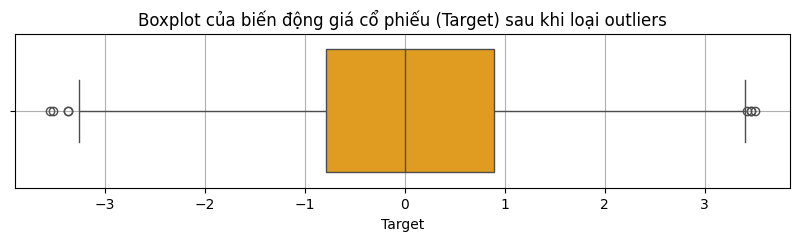

In [17]:
PNJ = remove_outliers_and_plot(PNJ)

- Thể hiện trên biểu đồ boxplot cho thấy có các giá trị outliers. Số lượng các giá trị này không quá nhiều (467 samples), nhưng nếu không loại bỏ có thể khiến model khó nắm bắt pattern. 
- Sau khi loại bỏ outliers, số lượng sample còn lại là 467.

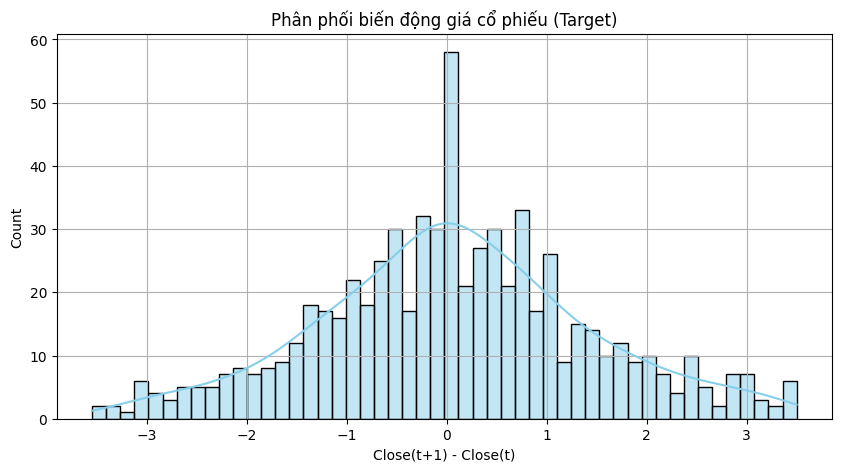

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(PNJ['Target'], kde=True, bins=50, color='skyblue')
plt.title('Phân phối biến động giá cổ phiếu (Target)')
plt.xlabel('Close(t+1) - Close(t)')
plt.grid(True)
plt.show()

Sau khi xử lý loại bỏ outliers
- Distribution có hình dạng gần giống Normal Distribution.
- Center của distribution gần 0, nghĩa là phần lớn biến động hàng ngày của cổ phiếu là nhỏ.
- Đỉnh nhọn bất thường tại 0 và hai đuôi dài, cho thấy khả năng có nhiều phiên không biến động và tồn tại những biến động lớn hơn mức bình thường (đuôi nặng).

## 2. Features engineering

- Thêm các features mới 

In [19]:
from preprocessing import feature_engineering

In [20]:
PNJ = feature_engineering(PNJ)

## 3. Data segregation

- Sau khi xử lý xong, data sẽ được chia thành các train, validate, test set để tiến hành train và evaluate model.

In [21]:
from data_segregation import split_time_series_data

In [22]:
features, target, X_trainval, X_test, y_trainval, y_test = split_time_series_data(PNJ)

- Kiểm tra lại shape của dataset trước khi vào bước train model.

In [23]:
X_trainval.shape

(519, 33)

In [24]:
X_test.shape

(130, 33)

In [25]:
y_trainval.shape

(519,)

In [26]:
y_test.shape

(130,)

# IV. Model

## 1. Training

- Sử dụng model LightGBM để predict chênh lệch giá.

In [27]:
from data_segregation import time_series_cv

In [28]:
cv_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42, verbosity=-1)

val_scores, val_preds, val_trues, val_dates = time_series_cv(
    model=cv_model,
    X=X_trainval,
    y=y_trainval,
    dates=PNJ, 
    n_splits=3
)

In [29]:
from visualization import plot_cv_predictions

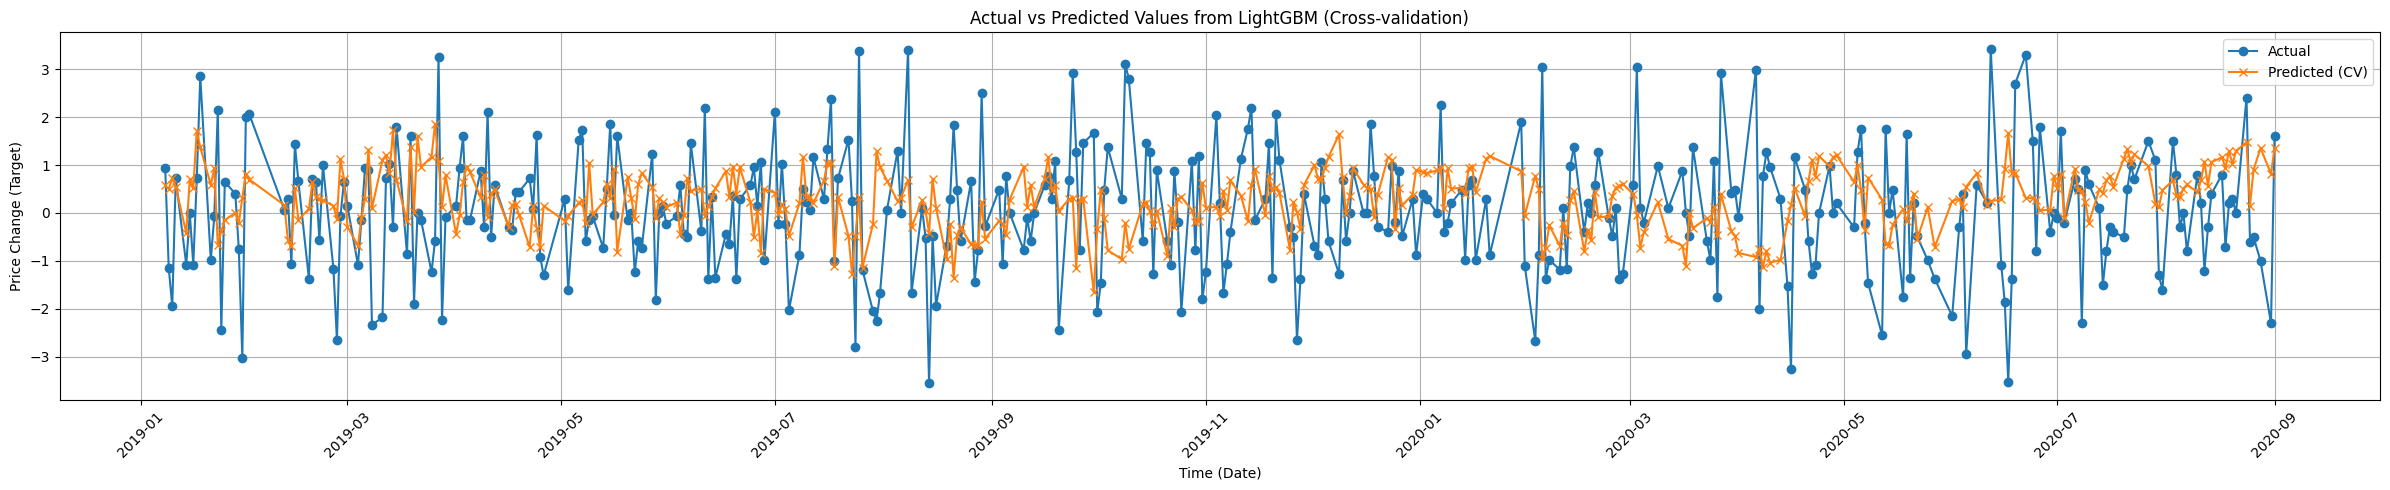

In [30]:
plot_cv_predictions(val_dates, val_trues, val_preds)

In [31]:
print(f"MAE trung bình (CV): {np.mean(val_scores):.4f}")

MAE trung bình (CV): 1.1350


- Model có xu hướng dự đoán khá sát với trung bình, nhưng chưa theo kịp các biến động lớn của giá thực tế. Điều này cho thấy mô hình dự đoán ổn định nhưng chưa nắm bắt được các cú sốc mạnh hoặc dao động lớn trên thị trường.
- MAE trên tập Cross-validation vào khoảng 1.1350 là khá cao với bài toán dự đoán biến động ngắn hạn. 

## 2. Tunning 

- Sử dụng Optuna để tìm bộ hyper-parameters tối ưu.
- Kết quả tối ưu được đánh giá trên tập Cross-validation.

In [32]:
from tunning import optuna_objective

In [33]:
objective = optuna_objective(X_trainval, y_trainval, loss_type="rmse_corr", n_splits=3)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-05-10 17:19:53,091] A new study created in memory with name: no-name-b7f9b82c-fc83-4ed0-8cb1-fb5bd42dbcac
[I 2025-05-10 17:19:53,378] Trial 0 finished with value: 1.5384711827924091 and parameters: {'n_estimators': 221, 'learning_rate': 0.06808534368509563, 'max_depth': 10, 'num_leaves': 33, 'min_child_samples': 12, 'subsample': 0.711815254709362, 'colsample_bytree': 0.633534031793387}. Best is trial 0 with value: 1.5384711827924091.
[I 2025-05-10 17:19:53,503] Trial 1 finished with value: 1.5652481976456096 and parameters: {'n_estimators': 205, 'learning_rate': 0.03650720651785134, 'max_depth': 4, 'num_leaves': 40, 'min_child_samples': 12, 'subsample': 0.625944546465373, 'colsample_bytree': 0.870048879217034}. Best is trial 0 with value: 1.5384711827924091.
[I 2025-05-10 17:19:53,651] Trial 2 finished with value: 1.6629660029328568 and parameters: {'n_estimators': 201, 'learning_rate': 0.1057973043730391, 'max_depth': 6, 'num_leaves': 63, 'min_child_samples': 14, 'subsample': 

Best hyperparameters: {'n_estimators': 57, 'learning_rate': 0.0134268417018632, 'max_depth': 8, 'num_leaves': 58, 'min_child_samples': 23, 'subsample': 0.9188139098275144, 'colsample_bytree': 0.8960065593848672}


## 3. Retraining and fetures importance

- Model sẽ được train lại một lần nữa với toàn bộ tập train và bộ hyper-parameter tối ưu vừa tìm được. 

In [34]:
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_trainval, y_trainval)

y_pred_test = best_model.predict(X_test)

In [35]:
importances = best_model.feature_importances_
feat_names = features.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df.head(10))

           Feature  Importance
29   Open_to_Close          98
4           Volume          63
24    Close_vs_MA5          55
14         Day_sin          55
7     volatility_5          55
28  Intraday_range          54
6         return_5          46
5           Return          39
3            Close          36
26    Volume_avg_5          33


- Các features được thêm vào có vai trò khá quan trọng, khi model dựa nhiều vào các features này để đưa ra quyết định.
- Các features có đóng góp nhiều nhất gồm: Open_to_Close, Return, Intraday_range, Volume_avg_5, Close_vs_MA5, Day_sin, Volatility_20, Volume, volatility_5, return_5, Close.

In [36]:
from visualization import plot_test_predictions

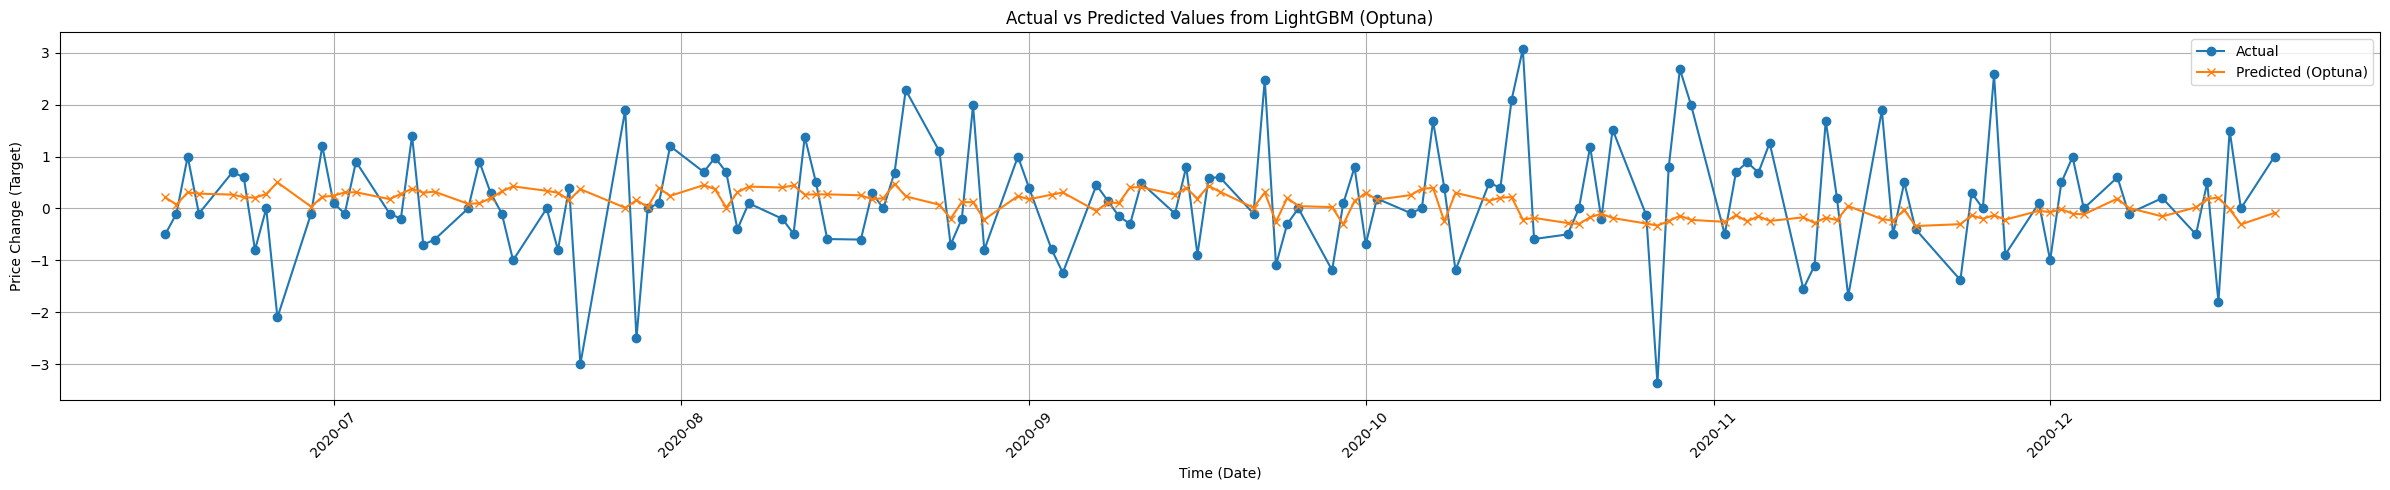

In [37]:
plot_test_predictions(PNJ.loc[y_test.index, 'Date'].values, y_test.values, y_pred_test)

In [38]:
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print(f"[Final Result]")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

[Final Result]
MAE: 0.8171
RMSE: 1.1013


- Tương tự như ở bộ dữ liệu MSN, mặc dù chỉ số MAE phản ánh model được cải thiện rõ rệt, nhưng sai số trung bình 0.8171 vẫn là khá lớn so với biến động trung bình.
- Hình ảnh trực quan hóa thể hiện khả năng bắt được các biến động của model kém hơn so hơn model khi chưa tunning.